# Project Plan

- I realized that the food information was really cool and interesting however I want to know if making the extra sacrifice to save on food is worth it.
- I realized that I am not interested in actually eating better or simply spending less money on food. I am interested in controlling my wealth.
- In other words, I want to have a clear view on how much wealth I have and if I am on track to meet my wealth goals. If I am not on track, what is pulling me away from my goals the most.

### Step 1: Stablishing goals

- My end financial goal is to have $500,000 in Capital
- I would like to know how far away I am from the goal.
    - How much money is left to reach $500,000
    - How many days I am away from reaching $500,000 (adjustable estimation)
- I would like to know how much each category of expense weights me down from reaching the $500,000 goal

### Step 2: Defining Data Needed

- Positive
    - Income Actual
    - Income Estimated
    - 401k Invested Me Actual
    - 401k Invested Me Estimated
    - 401k Invested Company Actual
    - 401k Invested Company Estimated 
    - 401k Earned Actual 
    - 401k Earned Estimated
    - Investments Earned Actual (not the amount invested, the amount earned) [Roth IRA or no]
    - Investments Earned Estimated (not the amount invested, the amount earned) [Roth IRA or no]
    - Savings Interest Actual
    - Savings Interest Estimated
    - Credit Card Cashback Actual
    - Credit Card Cashback Estimated

- Negative
    - Expenses Actual
    - Expenses Estimated (many categories with different values)

### Step 3: Defining Data Sources

- Positive
    - Income Actual: Income Sheet - Google Sheets (data inserted manually through the income form)
    - Income Estimated: __NOT DEFINED__ 
    - 401k Invested Me Actual: __NOT DEFINED__ (Fidelity)
    - 401k Invested Me Estimated: __NOT DEFINED__ 
    - 401k Invested Company Actual: __NOT DEFINED__ (Fidelity)
    - 401k Invested Company Estimated: __NOT DEFINED__ 
    - 401k Earned Actual: __NOT DEFINED__ (Fidelity)
    - 401k Earned Estimated: __NOT DEFINED__
    - Investments Earned Actual: __NOT DEFINED__ (Schwab)
    - Investments Earned Estimated: __NOT DEFINED__
    - Savings Interest Actual: __NOT DEFINED__ (Capital One)
    - Savings Interest Estimated: __NOT DEFINED__
    - Credit Card Cashback Actual: __NOT DEFINED__ (Capital One)
    - Credit Card Cashback Estimated: __NOT DEFINED__

- Negative
    - Expenses Actual: Expenses Sheet - Google Sheets (data inserted manually through the expense form)
    - Expenses Estimated: __NOT DEFINED__


### Step 4: Importing Data

Import libraries and set up secret keys


In [1]:

import gspread
import pandas as pd
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
from oauth2client.service_account import ServiceAccountCredentials
import smtplib
from email.message import EmailMessage
from dotenv import load_dotenv
import os
import mimetypes
from pathlib import Path
import json

#Load secret keys file - this won't be necessary for deployment later
load_dotenv()

# Set up credentials
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
# creds = ServiceAccountCredentials.from_json_keyfile_name(os.getenv('TRY'), scope)
json_keyfile_dict = json.loads(os.getenv('JSON_KEYFILE_DICT'))
creds = ServiceAccountCredentials.from_json_keyfile_dict(json_keyfile_dict, scope)
client = gspread.authorize(creds)

# Open Spreadsheet based on sheet key
spreadsheet_key = os.getenv('SPREADSHEET_KEY')
spreadsheet = client.open_by_key(spreadsheet_key)

C:\Users\lohan\AppData\Local\Temp\ipykernel_19488\3363425511.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Set Goal

In [40]:
goal = 500000

Get Income Sheet data

In [62]:
# Get Income Sheet data
sheet_title = 'Income'  
sheet = spreadsheet.worksheet(sheet_title)
income_actual = sheet.get_all_records()
income_actual = pd.DataFrame(income_actual)
income_actual['Timestamp'] = pd.to_datetime(income_actual['Timestamp'])

Get Expenses Sheet Data

In [63]:
# Get Expenses Sheet data
sheet_title = 'Expenses'  
sheet = spreadsheet.worksheet(sheet_title)
expenses_actual = sheet.get_all_records()
expenses_actual = pd.DataFrame(expenses_actual)
expenses_actual['Timestamp'] = pd.to_datetime(expenses_actual['Timestamp'])
expenses_actual['Income Amount'] = -expenses_actual['Expense Amount']

Make a simple line graph with actual income - actual expenses

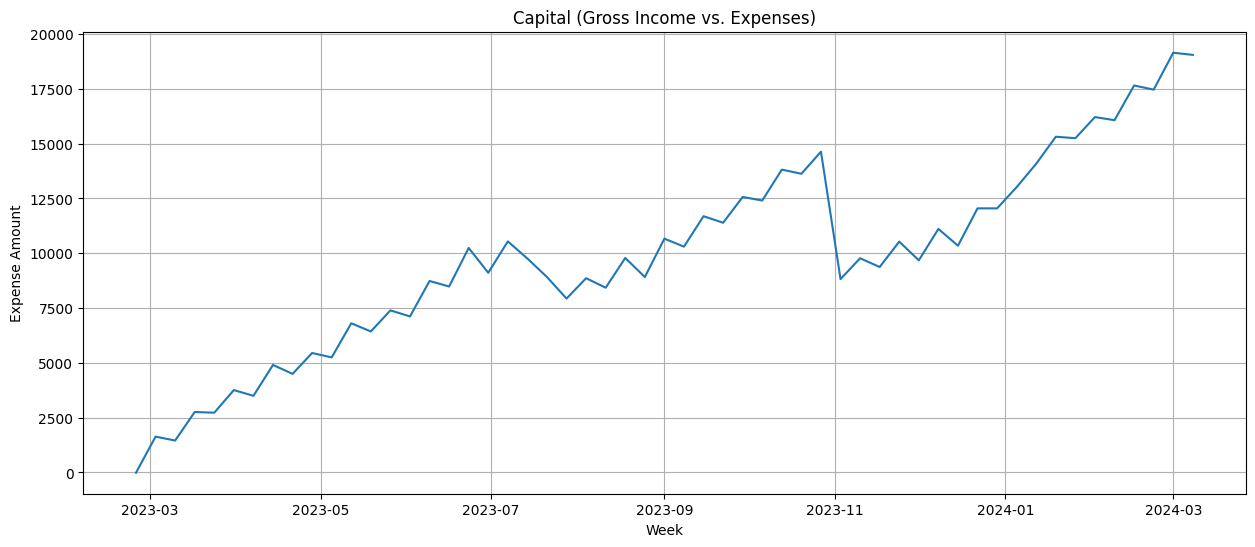

In [64]:
# DATA PROCESSING
# Merge both tables
stacked_actual_income_expenses = pd.concat([income_actual[['Timestamp', 'Income Amount']], expenses_actual[['Timestamp', 'Income Amount']]], axis=0, ignore_index=True)
stacked_actual_income_expenses = stacked_actual_income_expenses.sort_values(by='Timestamp')

# Set the 'Date' column as the index
stacked_actual_income_expenses.set_index('Timestamp', inplace=True)

# Resample and sum by week (assuming week starts on Sunday)
weekly_expenses = stacked_actual_income_expenses.resample('W-FRI').sum()
weekly_expenses['Actual'] = weekly_expenses['Income Amount'].cumsum()
#

# GRAPH
plt.figure(figsize=(15, 6))
plt.plot(weekly_expenses.index, weekly_expenses['Actual'])
plt.title('Capital (Gross Income vs. Expenses)')
plt.xlabel('Week')
plt.ylabel('Expense Amount')
plt.grid(True)
plt.show()

In [65]:
current_capital = weekly_expenses['Actual'].iloc[len(weekly_expenses['Actual'])-1].round(2)
how_far_away = goal - current_capital
percentage_complete = f'{(current_capital/goal*100).round(2)}%'

Get Weekly Estimated Expenses Data

In [89]:
# Get Weekly Estimated Expenses Sheet data
sheet_title = 'Expenses Estimated'  
sheet = spreadsheet.worksheet(sheet_title)
expenses_estimated = sheet.get_all_records()
expenses_estimated = pd.DataFrame(expenses_estimated)
weekly_expenses_estimated = expenses_estimated['Estimated Weekly Amount'].sum()

Get Weekly Estimated Income Data

In [72]:
sheet_title = 'Income Estimated'  
sheet = spreadsheet.worksheet(sheet_title)
income_estimated = sheet.get_all_records()
income_estimated = pd.DataFrame(income_estimated)
weekly_income_estimated = income_estimated['Estimated Weekly Amount'].sum()

In [ ]:
weekly_expenses['Estimated'] = weekly_income_estimated - weekly_expenses_estimated
weekly_expenses['Estimated'] = weekly_expenses['Estimated'].cumsum()
weekly_expenses

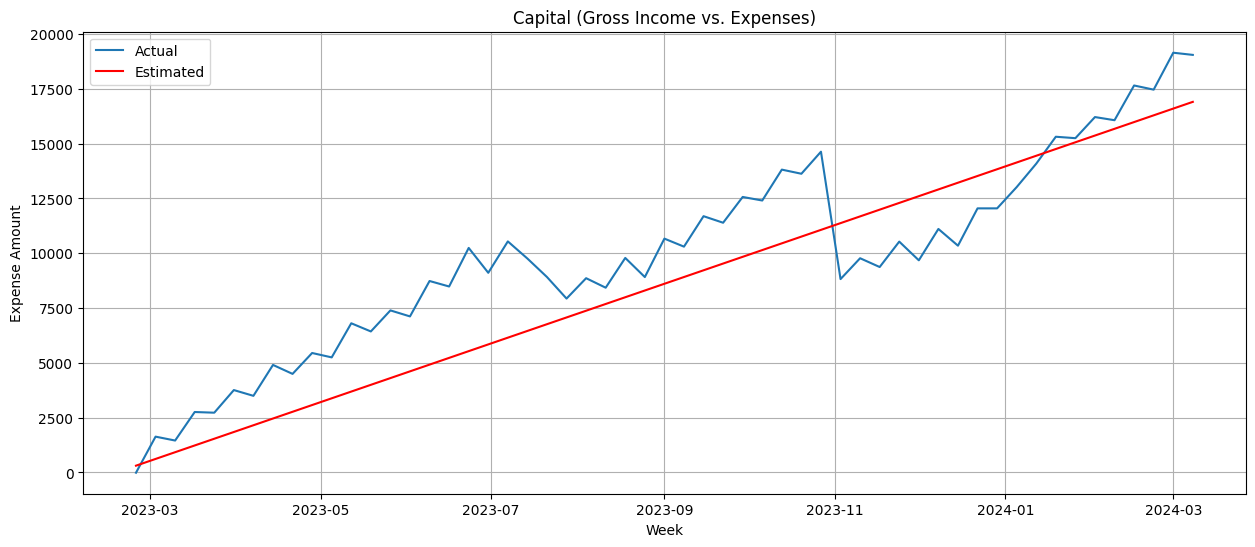

In [95]:
# GRAPH
plt.figure(figsize=(15, 6))
plt.plot(weekly_expenses.index, weekly_expenses['Actual'], label='Actual')
plt.plot(weekly_expenses.index, weekly_expenses['Estimated'], label='Estimated', color='red')
plt.title('Capital (Gross Income vs. Expenses)')
plt.xlabel('Week')
plt.ylabel('Expense Amount')
plt.legend()
plt.grid(True)
plt.show()